In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from statsmodels.tsa.api import SimpleExpSmoothing

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Ridge

In [2]:
train = pd.read_csv(r"data/processed/train.csv")
train.Date = pd.to_datetime(train.Date)

test = pd.read_csv(r"data/processed/test.csv")
test.Date = pd.to_datetime(test.Date)

У некоторых компаний слишком мало строк в тренировочном наборе, а именно 5-9 строк

In [3]:
train.groupby('Company')['Revenue'].count().sort_values().head(5)

Company
MNRL     5
MGY      9
BRY      9
XOG     16
CDEV    17
Name: Revenue, dtype: int64

### **Бейзлайн**

Exponential Smoothing

Для каждой компании обучим свою exp smoofing

In [7]:
import warnings
warnings.filterwarnings("ignore")

Revenue

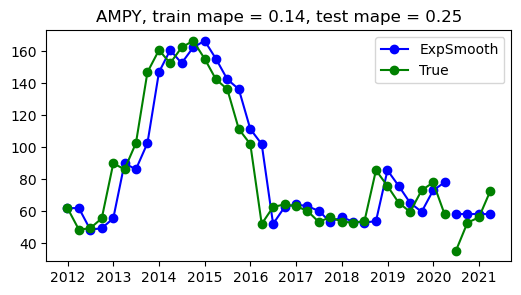

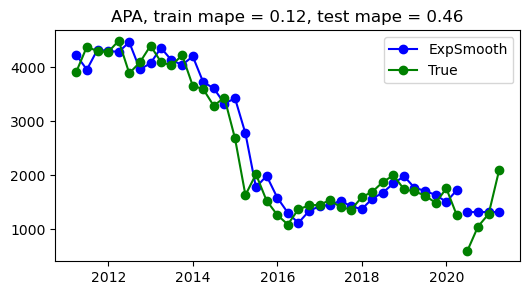

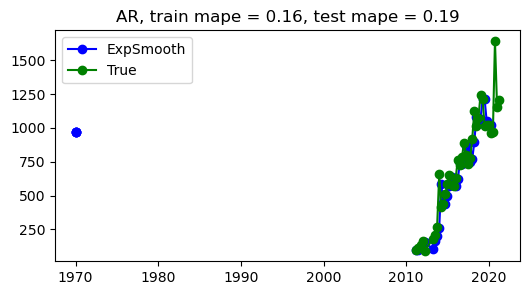

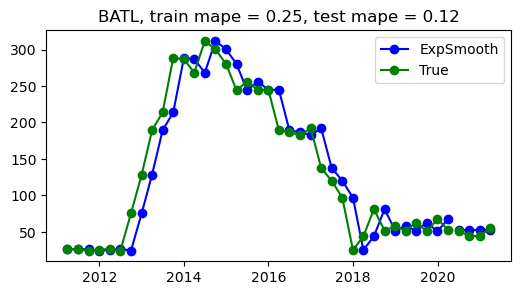

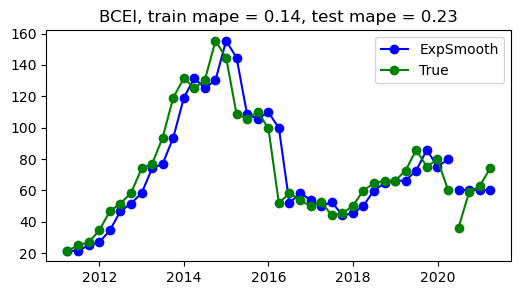

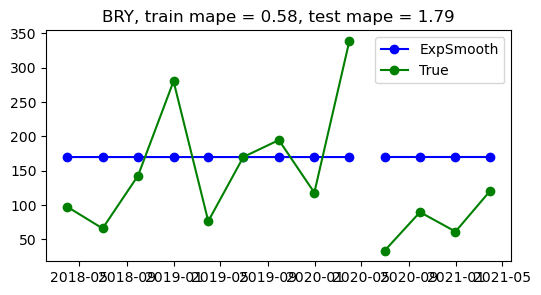

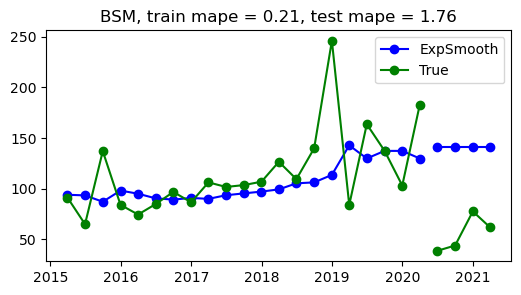

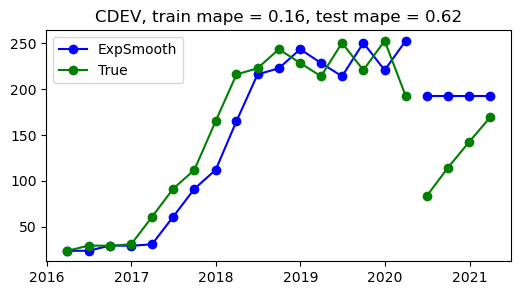

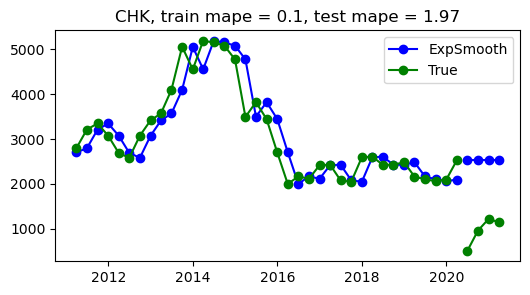

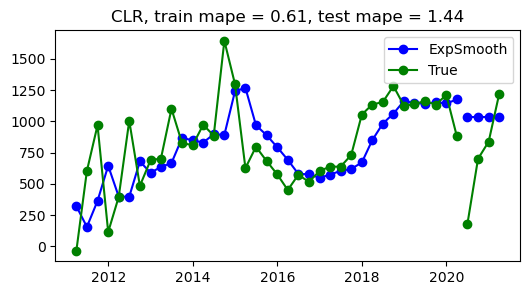

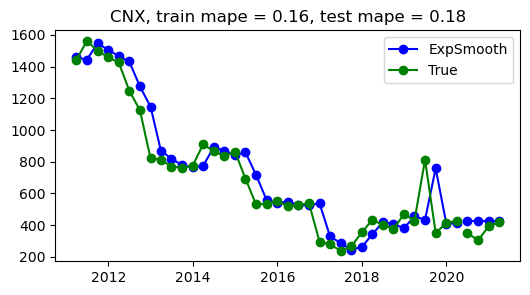

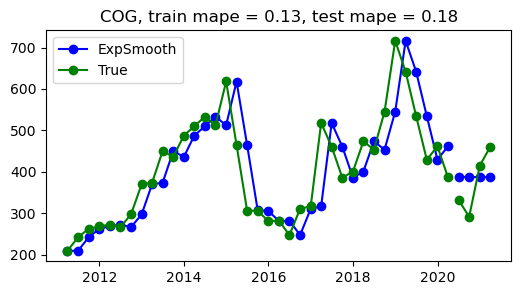

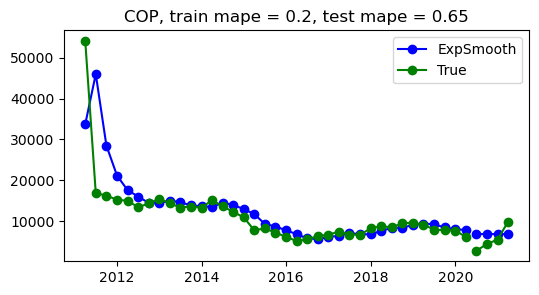

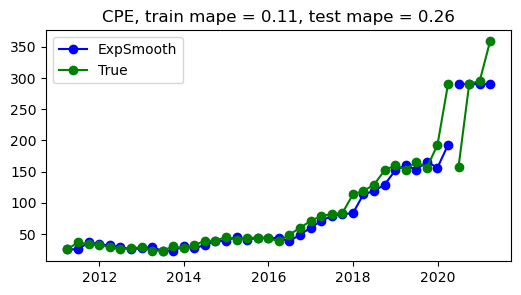

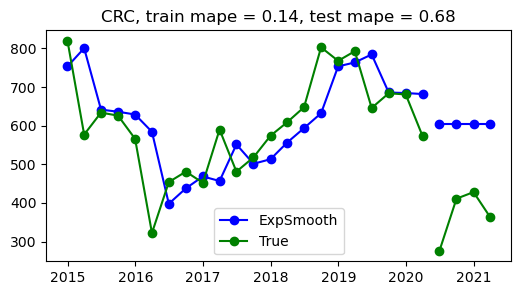

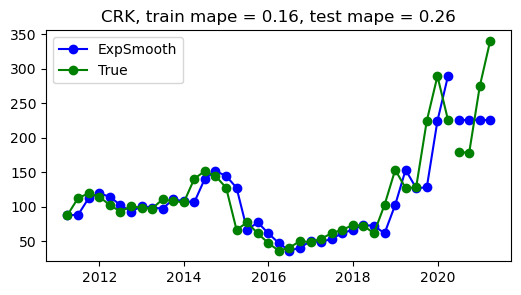

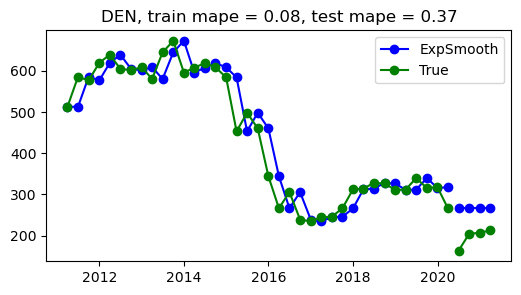

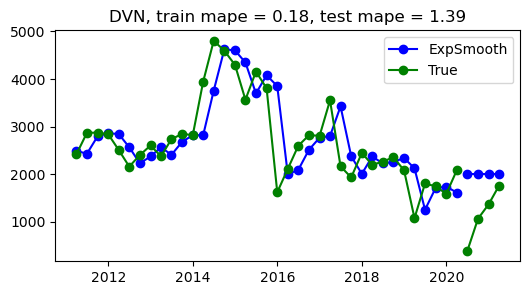

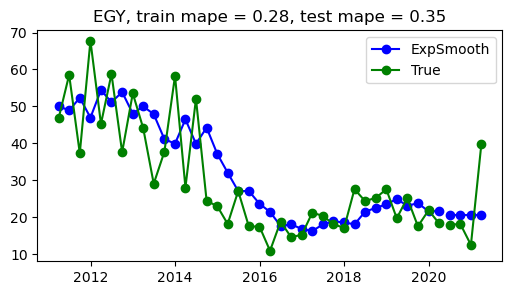

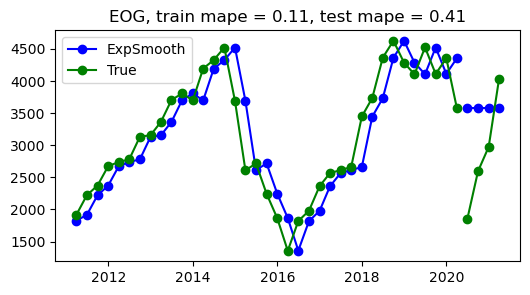

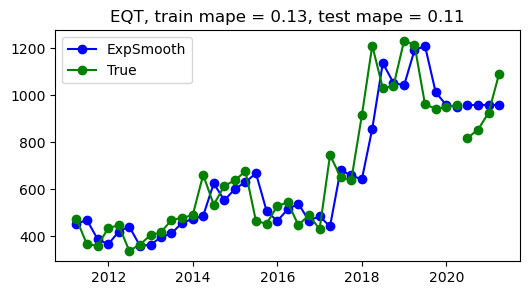

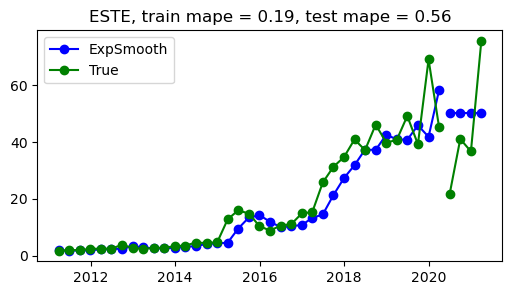

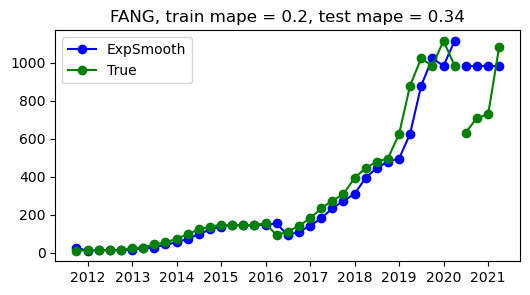

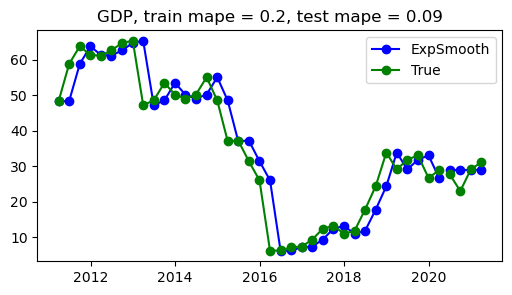

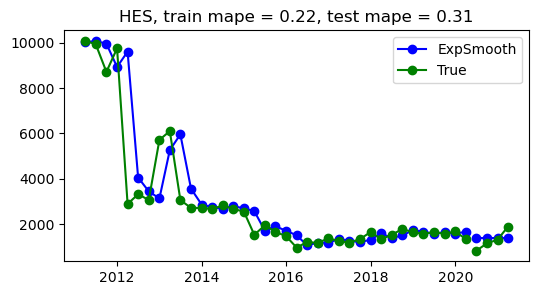

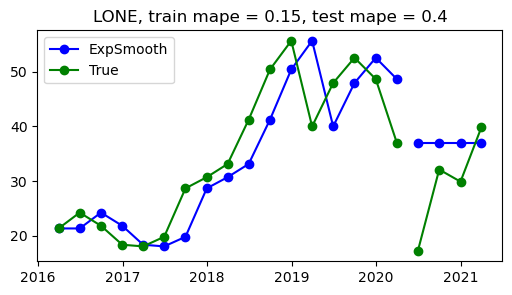

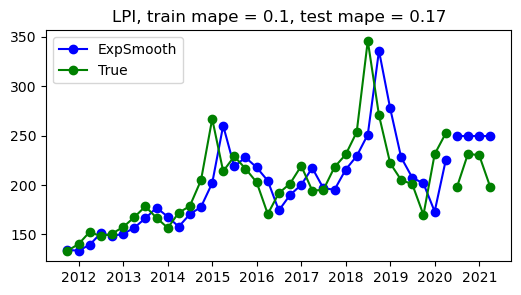

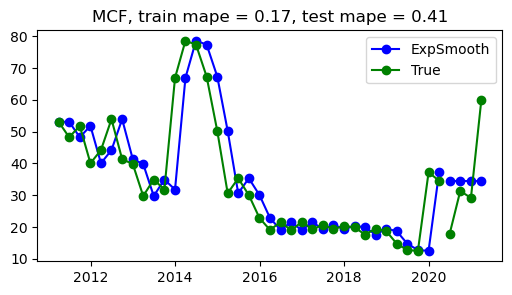

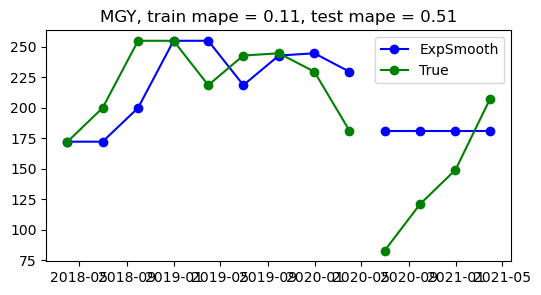

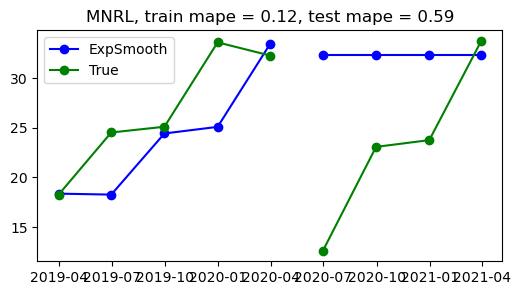

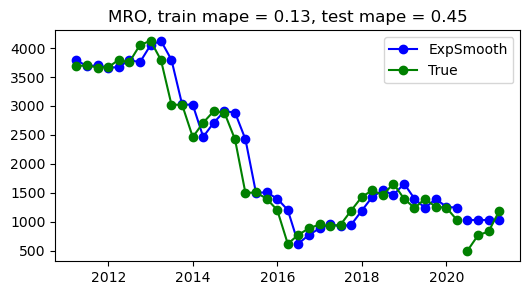

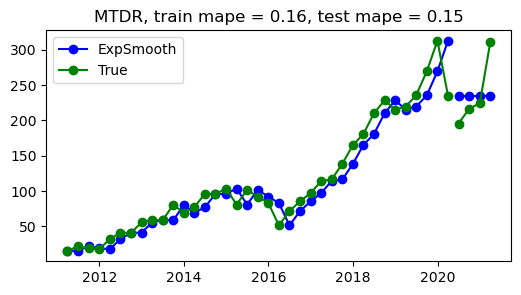

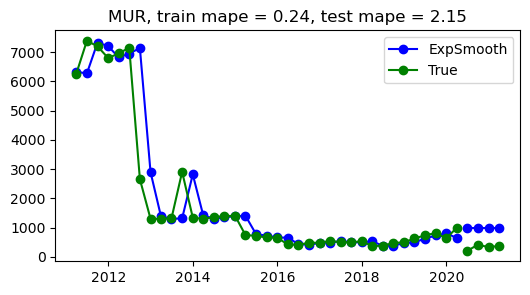

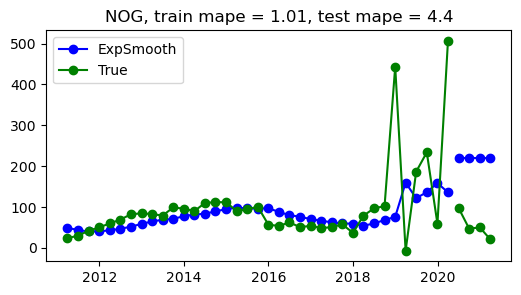

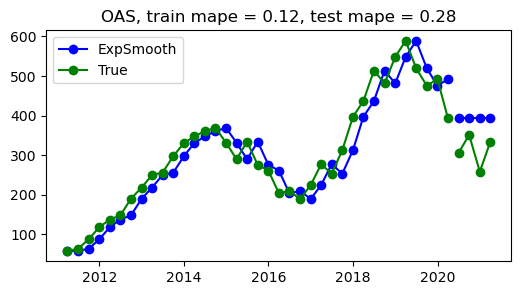

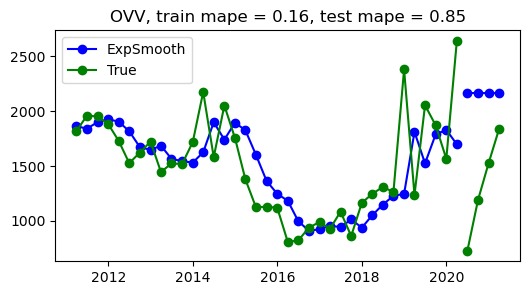

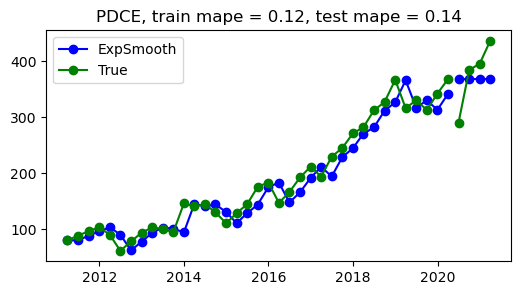

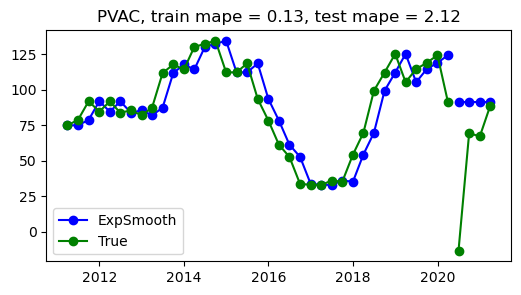

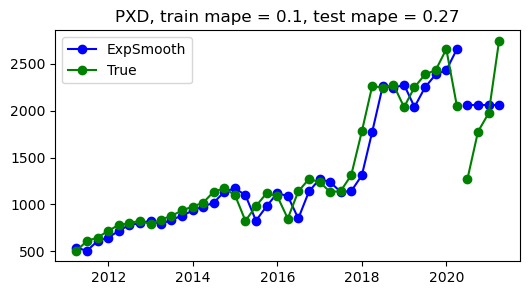

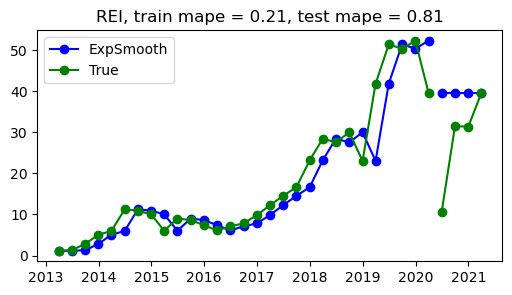

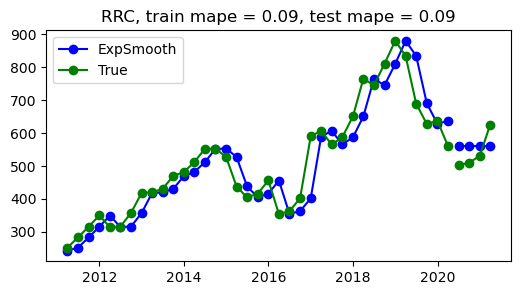

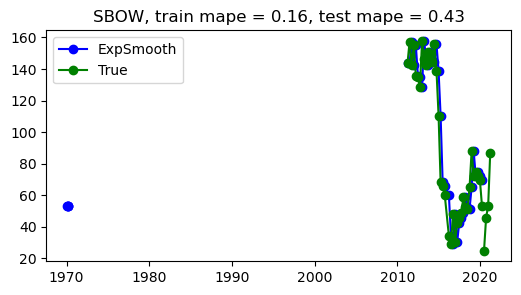

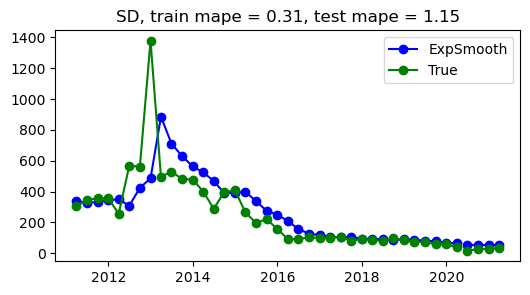

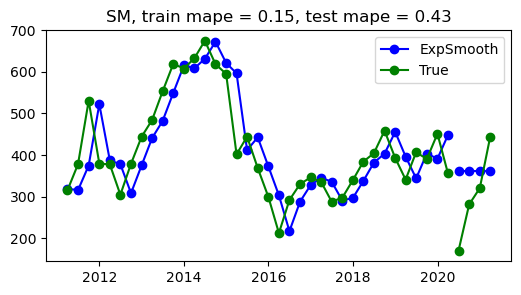

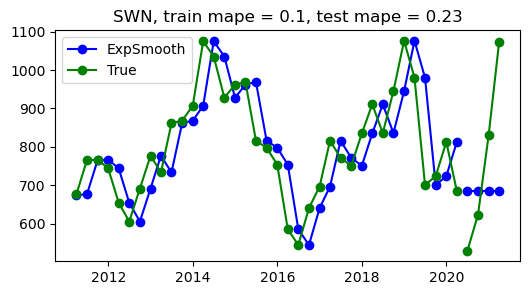

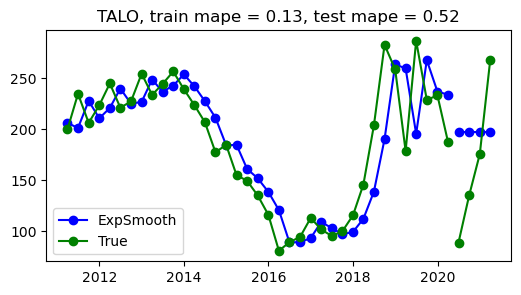

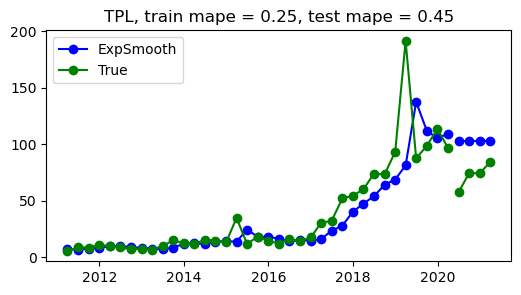

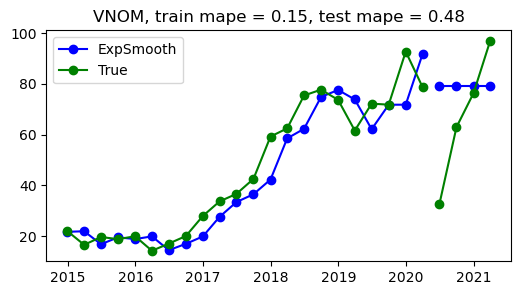

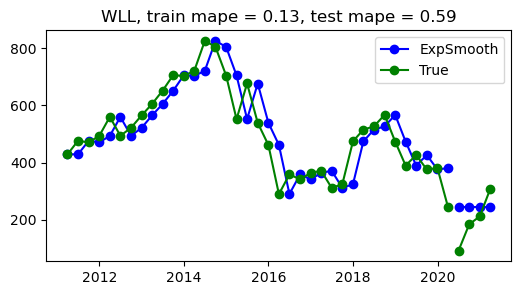

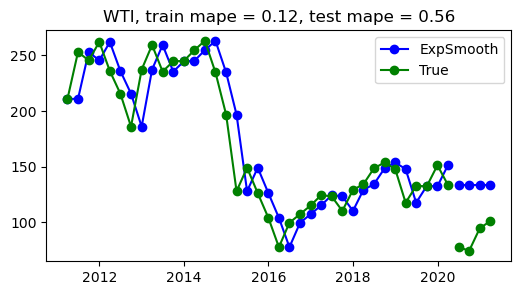

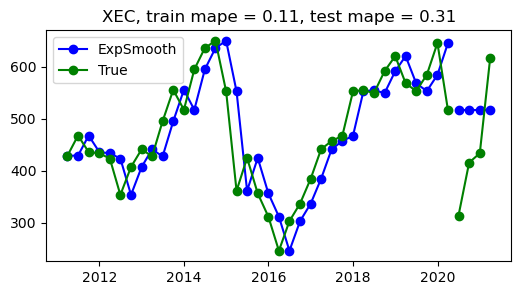

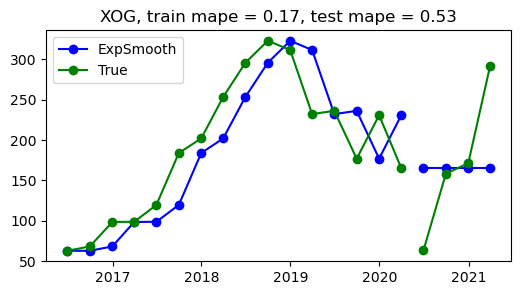

In [190]:
groups = train.groupby(by='Company')
train_mapes = []
test_mapes=[]
for company_name, group in groups:
    test_series = pd.Series(data =  np.array(test[test.Company == company_name]['Revenue']), index = test[test.Company == company_name]['Date'])
    series = pd.Series(data = np.array(group['Revenue']), index = group['Date'])
        
    smoof = SimpleExpSmoothing(series, initialization_method="estimated").fit()
    preds = smoof.fittedvalues
    forecast = smoof.forecast(4)
    
    train_mape = mean_absolute_percentage_error(series, preds)
    test_mape = mean_absolute_percentage_error(test_series, forecast)
    train_mapes.append(train_mape)
    test_mapes.append(test_mape)
    
    plt.figure(figsize=(6,3))
    plt.title(f'{company_name}, train mape = {np.round(train_mape,2)}, test mape = {np.round(test_mape,2)}')
    plt.plot(preds, marker="o", color="blue")
    (line1,) = plt.plot(forecast, marker="o", color="blue")
    plt.plot(series, marker='o', color = 'green')
    (line2,)= plt.plot(test_series, marker='o', color = 'green')
    plt.legend([line1, line2],['ExpSmooth','True'])
    plt.plot()
    
train_mapes = np.array(train_mapes)
test_mapes = np.array(test_mapes)

Operatinig Income

In [180]:
groups = train.groupby(by='Company')
train_mapes_income = []
test_mapes_income=[]
for company_name, group in groups:
    test_series = pd.Series(data =  np.array(test[test.Company == company_name]['Operating Income']), index = test[test.Company == company_name]['Date'])
    series = pd.Series(data = np.array(group['Operating Income']), index = group['Date'])
        
    smoof = SimpleExpSmoothing(series, initialization_method="estimated").fit()
    preds = smoof.fittedvalues
    forecast = smoof.forecast(4)
    
    train_mape = mean_absolute_percentage_error(series, preds)
    test_mape = mean_absolute_percentage_error(test_series, forecast)
    train_mapes_income.append(train_mape)
    test_mapes_income.append(test_mape)
    
    # plt.figure(figsize=(6,3))
    # plt.title(f'{company_name}, train mape = {np.round(train_mape,2)}, test mape = {np.round(test_mape,2)}')
    # plt.plot(preds, marker="o", color="blue")
    # (line1,) = plt.plot(forecast, marker="o", color="blue")
    # plt.plot(series, marker='o', color = 'green')
    # (line2,)= plt.plot(test_series, marker='o', color = 'green')
    # plt.legend([line1, line2],['ExpSmooth','True'])
    # plt.plot()
    
train_mapes_income = np.array(train_mapes_income)
test_mapes_income = np.array(test_mapes_income)

In [181]:
result = pd.DataFrame(columns = ['model','target','avg train mape', 'avg test mape', 'min train mape', 'min test mape', 'max train mape', 'max test mape'],
                     data = [['Exp smoth', 'Revenue', np.round(np.mean(train_mapes),2), np.round(np.mean(test_mapes),2),
                              np.round(np.min(train_mapes),2), np.round(np.min(test_mapes),2), np.round(np.max(train_mapes),2), np.round(np.max(test_mapes),2)],
                            ['Exp smoth', 'Operating Income', np.round(np.mean(train_mapes_income),2), np.round(np.mean(test_mapes_income),2),
                              np.round(np.min(train_mapes_income),2), np.round(np.min(test_mapes_income),2), np.round(np.max(train_mapes_income),2), np.round(np.max(test_mapes_income),2)]])

In [182]:
result

,model,target,avg train mape,avg test mape,min train mape,min test mape,max train mape,max test mape
0,Exp smoth,Revenue,0.19,0.66,0.08,0.09,1.01,4.40
1,Exp smoth,Operating Income,2.42,7.51,0.19,0.22,18.68,136.43


**Мысли по результатам**

Гигантские значение MAPE в Operating Income обусловленны тем, что Operating Income может крутиться в районе нуля из-за чего может получиться, что наше предсказание например 101, а истинный Operating Income = 1, тогда MAPE = 100. Revenue ведет себя более сдержано и у нуля не бывает.

### **Бейзлайн 2**

Линейная регрессия

У нас есть пара строк, где Revenue target и Operating Income target равны 0. Это критично, так как MAPE очень сильно карает за это, ведь во время подсчет метрики мы делим на 0. Заменим нули небольшими значениями.

In [122]:
train[(train['Revenue target'] == 0) | (train['Operating Income target'] == 0)]

,Revenue,Gross Profit,Operating Income,Pretax Income,Diluted EPS,EBITDA,ROA,ROE,Total Current Assets,Total Long-Term Assets,...,Total Equity,Cash from Operations,Cash from Investing Activities,Cash from Financing Activities,Date,Company,Revenue target,Operating Income target,Revenue target change,Operating Income target change
75,92.034,59.892,48.915,24.545,0.000000,97.443,0.011539,0.022134,274.606016,3344.187032,...,1673.736960,100.491,124.699,-222.040,2012-03-31,AR,0.000,0.0,-92.034,-48.915
1358,60.116,-4.949,-13.628,-33.066,-0.742289,21.978,-0.061005,0.000000,48.231000,976.047000,...,-324.810048,-1.029,-21.724,29.429,2015-09-30,SBOW,50.099,0.0,-10.017,13.628


In [126]:
idx = train[train['Revenue target'] == 0].index
train.loc[idx, 'Revenue target'] = 50
idx = train[train['Operating Income target'] == 0].index
train.loc[idx, 'Operating Income target'] = 50

Создаем наши фолды для кроссвалидации. Классический timeseries kfold split.

In [128]:
np.sort(train.Date.unique())

array(['2011-03-31T00:00:00.000000000', '2011-06-30T00:00:00.000000000',
       '2011-09-30T00:00:00.000000000', '2011-12-31T00:00:00.000000000',
       '2012-03-31T00:00:00.000000000', '2012-06-30T00:00:00.000000000',
       '2012-09-30T00:00:00.000000000', '2012-12-31T00:00:00.000000000',
       '2013-03-31T00:00:00.000000000', '2013-06-30T00:00:00.000000000',
       '2013-09-30T00:00:00.000000000', '2013-12-31T00:00:00.000000000',
       '2014-03-31T00:00:00.000000000', '2014-06-30T00:00:00.000000000',
       '2014-09-30T00:00:00.000000000', '2014-12-31T00:00:00.000000000',
       '2015-03-31T00:00:00.000000000', '2015-06-30T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000',
       '2017-03-31T00:00:00.000000000', '2017-06-30T00:00:00.000000000',
       '2017-09-30T00:00:00.000000000', '2017-12-31

In [129]:
train1 = train[train.Date <= '2018-09-30'].index
test1 =  train[(train.Date > '2018-09-30') & (train.Date <= '2019-03-31')].index

train2 = train[train.Date <= '2019-03-31'].index
test2 = train[(train.Date > '2019-03-31') & (train.Date <= '2019-09-30')].index

train3 = train[train.Date <= '2019-09-30'].index
test3 = train[train.Date > '2019-09-30'].index

kfolds = [(train1,test1),(train2,test2),(train3,test3)]

В обучении не будем использовать дефолтные revenue и operating income, а также признаки change, так как иначе будут проблемы на тестовом наборе данных

In [183]:
data_train = train.drop(columns = ['Revenue','Operating Income','Revenue target','Operating Income target','Revenue target change','Operating Income target change','Date','Company'])
data_test = test.drop(columns = ['Revenue','Operating Income','Revenue target','Operating Income target','Revenue target change','Operating Income target change','Date','Company'])

Revenue

In [184]:
target_train = train.loc[:,'Revenue target']
target_test = test.loc[:,'Revenue target']

In [185]:
train_mapes=[]
test_mapes=[]
for trn, tst in kfolds:
    model = Ridge(alpha = 0.2)
    model.fit(data_train.loc[trn,:], target_train[trn])
    
    preds = model.predict(data_train.loc[trn,:])
    test_preds = model.predict(data_train.loc[tst,:])
    
    train_mapes.append(mean_absolute_percentage_error(target_train[trn], preds))
    test_mapes.append(mean_absolute_percentage_error(target_train[tst], test_preds))
    
train_mapes = np.array(train_mapes)
test_mapes = np.array(test_mapes)

Operating Income

In [186]:
target_train = train.loc[:,'Operating Income target']
target_test = test.loc[:,'Operating Income target']

In [187]:
train_mapes_income=[]
test_mapes_income=[]
for trn, tst in kfolds:
    model = Ridge(alpha = 0.2)
    model.fit(data_train.loc[trn,:], target_train[trn])
    
    preds = model.predict(data_train.loc[trn,:])
    test_preds = model.predict(data_train.loc[tst,:])
    
    train_mapes_income.append(mean_absolute_percentage_error(target_train[trn], preds))
    test_mapes_income.append(mean_absolute_percentage_error(target_train[tst], test_preds))
    
train_mapes_income = np.array(train_mapes_income)
test_mapes_income = np.array(test_mapes_income)

In [188]:
result2 = pd.DataFrame(columns = ['model','target','avg train mape', 'avg test mape', 'min train mape', 'min test mape', 'max train mape', 'max test mape'],
                     data = [['Ridge reg', 'Revenue', np.round(np.mean(train_mapes),2), np.round(np.mean(test_mapes),2),
                              np.round(np.min(train_mapes),2), np.round(np.min(test_mapes),2), np.round(np.max(train_mapes),2), np.round(np.max(test_mapes),2)],
                            ['Ridge reg', 'Operating Income', np.round(np.mean(train_mapes_income),2), np.round(np.mean(test_mapes_income),2),
                              np.round(np.min(train_mapes_income),2), np.round(np.min(test_mapes_income),2), np.round(np.max(train_mapes_income),2), np.round(np.max(test_mapes_income),2)]])
result = result.append(result2)

### **Результаты**

В среднем экспоненциальное сглаживание лучше чем Ridge регрессия, однако в любом случае качество ужасное. Средняя ошибка на тесте по Operating Income может быть следствием одной гиганской ошибки в 136.43

In [189]:
result

,model,target,avg train mape,avg test mape,min train mape,min test mape,max train mape,max test mape
0,Exp smoth,Revenue,0.19,0.66,0.08,0.09,1.01,4.40
1,Exp smoth,Operating Income,2.42,7.51,0.19,0.22,18.68,136.43
0,Ridge reg,Revenue,0.98,0.90,0.93,0.54,1.01,1.14
1,Ridge reg,Operating Income,4.72,2.87,4.31,2.01,5.10,4.39
